## A/B Testing Results Analysis

Let us suppose that the A/B test was running for 2 weeks and we collected the following data:
- views.csv - the recommendation service responses
- likes.csv - the actual likes by users

In [1]:
import pandas as pd
import numpy as np
import hashlib

In [2]:
views = pd.read_csv('views.csv')
views

,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825
3,37703,test,[2842 1949 162 1588 6794],1654030826
4,14661,test,[2395 5881 5648 3417 673],1654030829
...,...,...,...,...
193290,158267,test,[1733 6834 4380 1915 1627],1655240340
193291,63527,control,[2454 191 3873 6404 1588],1655240347
193292,52169,test,[1368 1709 1616 798 5305],1655240354
193293,142402,test,[5895 6984 1978 6548 6106],1655240373


In [3]:
likes = pd.read_csv('likes.csv')
likes

,user_id,post_id,timestamp
0,128381,4704,1654030804
1,146885,1399,1654030816
2,50948,2315,1654030828
3,14661,673,1654030831
4,37703,1588,1654030833
...,...,...,...
230171,31851,5964,1655243535
230172,51512,1498,1655243537
230173,34017,5009,1655243573
230174,13267,1787,1655243692


Let's check if the groups split is correct and consistent:

In [4]:
# Check that each user belongs to only 1 experiment group

user_n_groups = views.groupby(by='user_id')['exp_group'].nunique()
user_n_groups[user_n_groups > 1]

user_id
25623     2
55788     2
142283    2
148670    2
Name: exp_group, dtype: int64

In [5]:
# Remove entries with broken users

user_to_drop = user_n_groups[user_n_groups > 1].index
views = views[~views.user_id.isin(user_to_drop)]
likes = likes[~likes.user_id.isin(user_to_drop)]

In [8]:
# Check the sizes of experiment groups

views.groupby(by='exp_group')['user_id'].nunique()

exp_group
control    32350
test       32659
Name: user_id, dtype: int64

In [10]:
# Make sure the split is equal using binomial test
# p-value > 0.05, so we accept the null hypothesis - split is equal

from scipy.stats import binomtest

binomtest(k=32659, n=32659+32350, p=0.5)

BinomTestResult(k=32659, n=65009, alternative='two-sided', proportion_estimate=0.5023765940100602, pvalue=0.2270501563614752)

#### **Simple Metric - Amount of Likes**

In [63]:
total_likes = likes.groupby('user_id').agg(
    likes_count=('post_id', 'count'))
total_likes

,likes_count
user_id,
200,1
201,3
202,2
212,4
213,7
...,...
168525,2
168532,4
168538,5


In [86]:
# Amount of likes by all users in the experiment

exp_users = views.groupby('user_id').count()
exp_users_likes = exp_users.join(total_likes).drop(['exp_group', 'recommendations', 'timestamp'], axis=1).fillna(0).astype(int)
exp_users_likes

,likes_count
user_id,
200,1
201,3
202,2
212,4
213,7
...,...
168538,5
168541,2
168544,0


In [70]:
# Share of users who liked at least one post

len(exp_users_likes[exp_users_likes.likes_count > 0]) / len(exp_users_likes)

0.8947530341952653

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

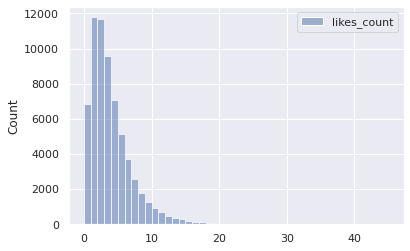

In [85]:
sns.set_theme()
sns.histplot(exp_users_likes, bins=45)
plt.show()
# Distribution seems like log-normal, therefore we should use the Mann-Whitney U test

In [87]:
# Amount of likes by users from control group

control_users = views[views.exp_group == 'control'].groupby('user_id').count()
control_users_likes = control_users.join(total_likes).drop(['exp_group', 'recommendations', 'timestamp'], axis=1).fillna(0).astype(int)
control_users_likes

,likes_count
user_id,
217,4
221,5
229,3
233,3
234,4
...,...
168519,0
168525,2
168526,0


In [88]:
# Amount of likes by users from test group

test_users = views[views.exp_group == 'test'].groupby('user_id').count()
test_users_likes = test_users.join(total_likes).drop(['exp_group', 'recommendations', 'timestamp'], axis=1).fillna(0).astype(int)
test_users_likes

,likes_count
user_id,
200,1
201,3
202,2
212,4
213,7
...,...
168521,3
168532,4
168538,5


In [97]:
print(f'Share of users who liked at least one post (Control group): {len(control_users_likes[control_users_likes.likes_count > 0]) / len(control_users_likes)}')
print(f'Share of users who liked at least one post (Test group): {len(test_users_likes[test_users_likes.likes_count > 0]) / len(test_users_likes)}')

Share of users who liked at least one post (Control group): 0.8913137557959815
Share of users who liked at least one post (Test group): 0.8981597721914327


In [93]:
# Performing Mann-Whitney U test on the amount of likes by users
# p-value is less than 0.05, so we take alternative hypothesis - metric is improved.

from scipy.stats import mannwhitneyu

mannwhitneyu(control_users_likes, test_users_likes)

MannwhitneyuResult(statistic=array([5.18358073e+08]), pvalue=array([2.95850628e-05]))

#### **Advanced Metric - Hitrate**

In [117]:
df_views = views.set_index('user_id')
df_views

,exp_group,recommendations,timestamp
user_id,,,
128381,control,[3644 4529 4704 5294 4808],1654030803
146885,test,[1399 1076 797 7015 5942],1654030811
50948,test,[2315 3037 1861 6567 4093],1654030825
37703,test,[2842 1949 162 1588 6794],1654030826
14661,test,[2395 5881 5648 3417 673],1654030829
...,...,...,...
158267,test,[1733 6834 4380 1915 1627],1655240340
63527,control,[2454 191 3873 6404 1588],1655240347
52169,test,[1368 1709 1616 798 5305],1655240354


In [119]:
df_likes = likes.set_index('user_id')
df_likes

,post_id,timestamp
user_id,,
128381,4704,1654030804
146885,1399,1654030816
50948,2315,1654030828
14661,673,1654030831
37703,1588,1654030833
...,...,...
31851,5964,1655243535
51512,1498,1655243537
34017,5009,1655243573


In [136]:
# Get all records in the same dataframe

df_join = df_views.join(df_likes, how='outer', lsuffix='_view', rsuffix='_like').fillna(0)
df_join.post_id = df_join.post_id.astype(int)
df_join.timestamp_like = df_join.timestamp_like.astype(int)
df_join

,exp_group,recommendations,timestamp_view,post_id,timestamp_like
user_id,,,,,
200,test,[5559 5510 4127 5135 1563],1655009047,5559,1655009084
201,test,[5094 4616 2461 138 1467],1654043283,3401,1654445547
201,test,[5094 4616 2461 138 1467],1654043283,2631,1654664040
201,test,[5094 4616 2461 138 1467],1654043283,6881,1654664052
201,test,[ 826 6966 7168 1360 3294],1654173790,3401,1654445547
...,...,...,...,...,...
168545,test,[3168 1167 659 6383 6848],1654887207,6581,1654295292
168545,test,[3168 1167 659 6383 6848],1654887207,1306,1654412185
168545,test,[3168 1167 659 6383 6848],1654887207,3168,1654887262


In [144]:
# Now we have to filter:
# 1. Liked before recommendations
# 2. Liked long after recommendations (assume > 1 hour after)

df_join['legit_like'] = np.where(
    (df_join['timestamp_view'] <= df_join['timestamp_like']) & (df_join['timestamp_like'] <= df_join['timestamp_view'] + 3600), 
    1, 0)
df_join

,exp_group,recommendations,timestamp_view,post_id,timestamp_like,legit_like
user_id,,,,,,
200,test,[5559 5510 4127 5135 1563],1655009047,5559,1655009084,1
201,test,[5094 4616 2461 138 1467],1654043283,3401,1654445547,0
201,test,[5094 4616 2461 138 1467],1654043283,2631,1654664040,0
201,test,[5094 4616 2461 138 1467],1654043283,6881,1654664052,0
201,test,[ 826 6966 7168 1360 3294],1654173790,3401,1654445547,0
...,...,...,...,...,...,...
168545,test,[3168 1167 659 6383 6848],1654887207,6581,1654295292,0
168545,test,[3168 1167 659 6383 6848],1654887207,1306,1654412185,0
168545,test,[3168 1167 659 6383 6848],1654887207,3168,1654887262,1


In [168]:
legit_likes = df_join.groupby(['user_id', 'exp_group', 'recommendations'])['legit_like'].sum()
legit_likes

user_id  exp_group  recommendations           
200      test       [5559 5510 4127 5135 1563]    1
201      test       [ 384  371 1420 5994  370]    0
                    [ 826 6966 7168 1360 3294]    0
                    [4962 6881 2631  643 6168]    2
                    [5094 4616 2461  138 1467]    0
                                                 ..
168545   test       [1306 3060 4732 4887 3178]    1
                    [3168 1167  659 6383 6848]    1
                    [5115  983 2152  591 2970]    2
168552   control    [  93 4558 4130 6918 3769]    0
                    [1566 2670 3584 3643  901]    0
Name: legit_like, Length: 193268, dtype: int64

In [191]:
# Share of recommendations with at least 1 legit like (total)

legit_likes[legit_likes > 0].count() / legit_likes.count()

0.71529171927065

In [186]:
# Sub-series for control and test groups

control_legit_likes = legit_likes[legit_likes.index.get_level_values(1) == 'control']
test_legit_likes = legit_likes[legit_likes.index.get_level_values(1) == 'test']

In [190]:
# Share of recommendations with at least 1 legit like
# for control group
# for test group

print(control_legit_likes[control_legit_likes > 0].count() / control_legit_likes.count())
print(test_legit_likes[test_legit_likes > 0].count() / test_legit_likes.count())

0.7086541454809588
0.7218931247290966


In [217]:
# Let's use bucketing method to perform statistical test on grouped hitrate

df_legit_likes = legit_likes.to_frame()
df_legit_likes = df_legit_likes.reset_index()
df_legit_likes

,user_id,exp_group,recommendations,legit_like
0,200,test,[5559 5510 4127 5135 1563],1
1,201,test,[ 384 371 1420 5994 370],0
2,201,test,[ 826 6966 7168 1360 3294],0
3,201,test,[4962 6881 2631 643 6168],2
4,201,test,[5094 4616 2461 138 1467],0
...,...,...,...,...
193263,168545,test,[1306 3060 4732 4887 3178],1
193264,168545,test,[3168 1167 659 6383 6848],1
193265,168545,test,[5115 983 2152 591 2970],2
193266,168552,control,[ 93 4558 4130 6918 3769],0


In [198]:
df_legit_likes['bucket'] = df_legit_likes['user_id'].apply(
    lambda x: int(hashlib.md5((str(x) + 'salt').encode()).hexdigest(), 16) % 100
)
df_legit_likes

,user_id,exp_group,recommendations,legit_like,bucket
0,200,test,[5559 5510 4127 5135 1563],1,36
1,201,test,[ 384 371 1420 5994 370],0,14
2,201,test,[ 826 6966 7168 1360 3294],0,14
3,201,test,[4962 6881 2631 643 6168],2,14
4,201,test,[5094 4616 2461 138 1467],0,14
...,...,...,...,...,...
193263,168545,test,[1306 3060 4732 4887 3178],1,5
193264,168545,test,[3168 1167 659 6383 6848],1,5
193265,168545,test,[5115 983 2152 591 2970],2,5
193266,168552,control,[ 93 4558 4130 6918 3769],0,98


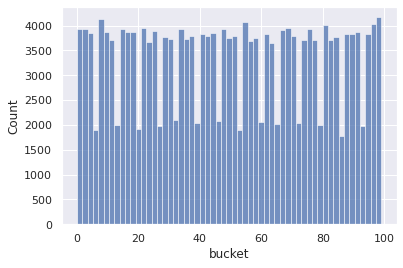

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
sns.histplot(df_legit_likes.bucket)
plt.show()

In [208]:
# Total recommendations count for each bucket

df_bucket_recs = df_legit_likes.groupby(['exp_group', 'bucket']).count().reset_index().drop(['user_id', 'legit_like'], axis=1)
df_bucket_recs

,exp_group,bucket,recommendations
0,control,0,1045
1,control,1,932
2,control,2,964
3,control,3,924
4,control,4,978
...,...,...,...
195,test,95,917
196,test,96,990
197,test,97,961
198,test,98,1045


In [214]:
# Legit likes count for each bucket

df_bucket_likes = df_legit_likes[df_legit_likes.legit_like > 0].groupby(['exp_group', 'bucket']).count().reset_index().drop(['user_id', 'recommendations'], axis=1)
df_bucket_likes

,exp_group,bucket,legit_like
0,control,0,779
1,control,1,638
2,control,2,673
3,control,3,653
4,control,4,683
...,...,...,...
195,test,95,669
196,test,96,727
197,test,97,719
198,test,98,767


In [216]:
df_bucket = pd.merge(df_bucket_recs, df_bucket_likes)
df_bucket['hitrate'] = df_bucket['legit_like'] / df_bucket['recommendations']
df_bucket

,exp_group,bucket,recommendations,legit_like,hitrate
0,control,0,1045,779,0.745455
1,control,1,932,638,0.684549
2,control,2,964,673,0.698133
3,control,3,924,653,0.706710
4,control,4,978,683,0.698364
...,...,...,...,...,...
195,test,95,917,669,0.729553
196,test,96,990,727,0.734343
197,test,97,961,719,0.748179
198,test,98,1045,767,0.733971


In [220]:
# Performing Mann-Whitney U test on the grouped hitrate metric
# p-value is less than 0.05, so we accept alternative hypothesis - metric is improved!

mannwhitneyu(df_bucket[df_bucket.exp_group == 'control'].hitrate, df_bucket[df_bucket.exp_group == 'test'].hitrate)

MannwhitneyuResult(statistic=2932.5, pvalue=4.4067700151880956e-07)

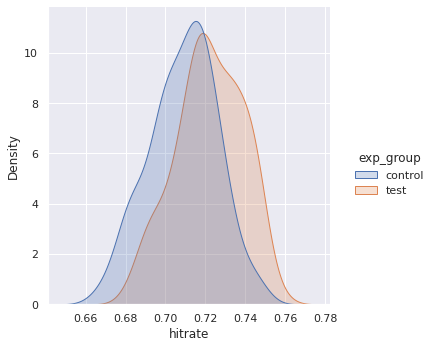

In [240]:
# Visualizing hitrate metric improvement

sns.displot(df_bucket, x='hitrate', hue='exp_group', kind='kde', fill='True')
plt.show()